In [1]:
import cv2
import skimage
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the images
p1 = cv2.imread('task_3_image_1.png')
p2 = cv2.imread('task_3_image_2.png')

In [3]:
p1.shape, p2.shape

((3006, 4202, 3), (3006, 4202, 3))

In [4]:
print(type(p1))
print(p1.dtype)

<class 'numpy.ndarray'>
uint8


In [5]:
print(f'Number of channels: {p1.shape[2]}')

Number of channels: 3


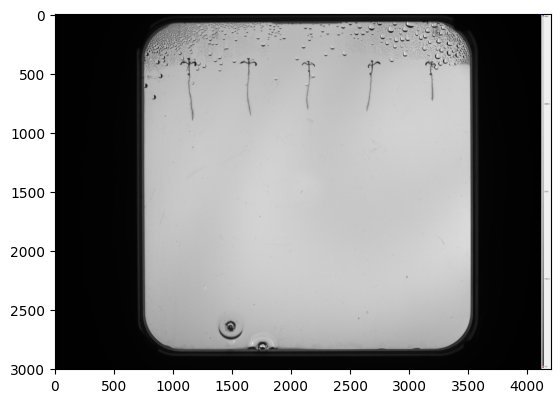

In [6]:
plt.imshow(p1, cmap='gray')

In [7]:
# Defining trimming function (from task 2)
def trim_picture(picture):
    picture = picture[:, :-150, :]
    xo, yo, zo = picture.shape
    x1 = xo//2
    valid_columns = (picture[x1, :, :] >= 100).any(axis=1)
    trimmed_picture1 = picture[:, valid_columns, :] 
    x_trimmed, y_trimmed, z_trimmed = trimmed_picture1.shape
    y2 = y_trimmed//2
    valid_rows = (trimmed_picture1[:, y2, :] >= 100).any(axis=1)
    trimmed_picture2 = trimmed_picture1[valid_rows, :, :]
    x, y, z = trimmed_picture2.shape
    if x == y:
        return trimmed_picture2
    min_dim = min(x, y)
    if x > y:
        excess = x - min_dim
        start = excess // 2
        end = start + min_dim 
        squared_picture = trimmed_picture2[start:end, :, :] 
    else: 
        excess = y - min_dim
        start = excess // 2
        end = start + min_dim
        squared_picture = trimmed_picture2[:, start:end, :]
    return squared_picture

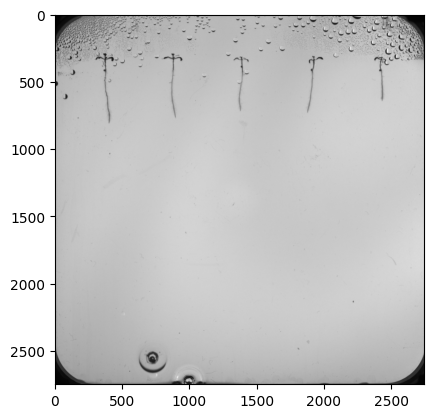

In [8]:
# Trimming the first picture
p1 = cv2.imread('task_3_image_1.png')
p1 = trim_picture(p1)
plt.imshow(p1, cmap='gray')

In [12]:
x, y, z = p1.shape

In [14]:
x, y

(2748, 2748)

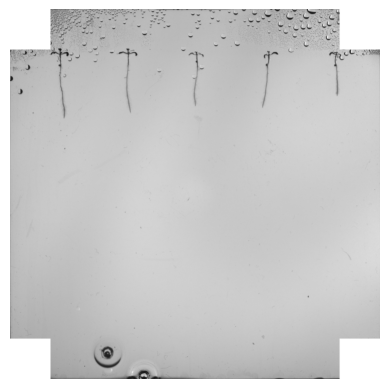

In [36]:
# putting mask on top if the image to cover the corners

mask = np.full((p1.shape[0], p1.shape[1]), 255, dtype="uint8")

rectangles = [
    ((0, 0), (300, 300)),  
    ((x-300, 0), (x, 300)),  
    ((0, p1.shape[0]-300), (300, p1.shape[0])),  
    ((x-300, p1.shape[0]-300), (x, p1.shape[0]))  
]

for top_left, bottom_right in rectangles:
    cv2.rectangle(mask, top_left, bottom_right, 0, -1) 

masked_image = p1.copy()
masked_image[mask == 0] = [255, 255, 255]  

plt.figure()
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [37]:
masked_image.dtype

dtype('uint8')

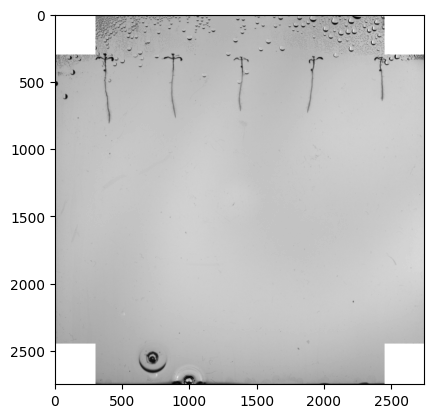

In [43]:
# converting the image to grayscale
gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

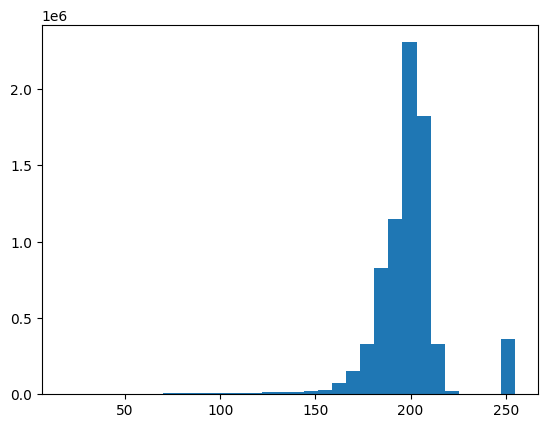

In [44]:
# histogram of the image's pixel values
n, bins, patches = plt.hist(gray_image.reshape(-1,), bins=32)

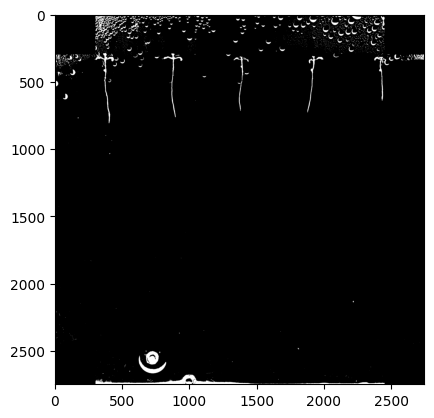

In [62]:
# tresholding the image
th, output_im = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY_INV)
plt.imshow(output_im, cmap='gray')

In [63]:
# connected components
retval1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(output_im)
retval1

2017

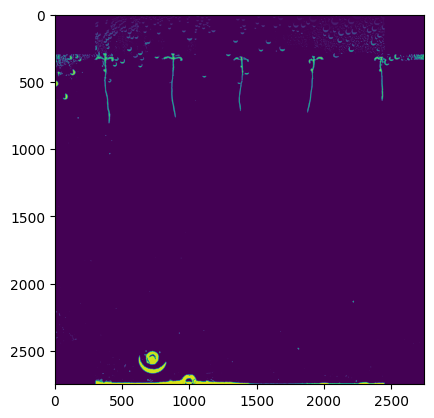

In [64]:
plt.imshow(labels1, cmap='viridis')

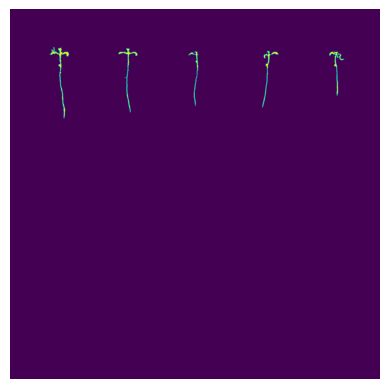

In [ ]:
# sorting the connected components by their height and picking top 5
object_indices = np.argsort(stats1[1:, cv2.CC_STAT_HEIGHT])[::-1]
top_5_indices = object_indices[:5] + 1  

top_5_mask = np.isin(labels1, top_5_indices).astype("uint8") * 255

plt.figure()
plt.imshow(top_5_mask)
plt.axis('off')
plt.show()

In [ ]:
# Putting everything together in a function
def process_and_trim_picture(picture):
    
    # Trim off 150 columns on the right
    picture = picture[:, :-150, :]
    xo, yo, zo = picture.shape
    x1 = xo // 2

    #Trim horizontally
    valid_columns = (picture[x1, :, :] >= 100).any(axis=1)
    trimmed_picture1 = picture[:, valid_columns, :] 

    # Trim vertically
    x_trimmed, y_trimmed, z_trimmed = trimmed_picture1.shape
    y2 = y_trimmed // 2
    valid_rows = (trimmed_picture1[:, y2, :] >= 100).any(axis=1)
    trimmed_picture2 = trimmed_picture1[valid_rows, :, :]

    # Adjust to square 
    x, y, z = trimmed_picture2.shape
    if x != y:
        min_dim = min(x, y)
        if x > y:
            excess = x - min_dim
            start = excess // 2
            end = start + min_dim 
            trimmed_picture2 = trimmed_picture2[start:end, :, :] 
        else: 
            excess = y - min_dim
            start = excess // 2
            end = start + min_dim
            trimmed_picture2 = trimmed_picture2[:, start:end, :]

    # Create a mask to exclude corners
    x, y, z = trimmed_picture2.shape
    mask = np.full((x, y), 255, dtype="uint8")

    # Define rectangles for corner masking
    rectangles = [
        ((0, 0), (300, 300)),  
        ((x-300, 0), (x, 300)),  
        ((0, y-300), (300, y)),  
        ((x-300, y-300), (x, y))  
    ]

    # Apply mask on corners
    for top_left, bottom_right in rectangles:
        cv2.rectangle(mask, top_left, bottom_right, 0, -1) 

    # Copy and mask the image
    masked_image = trimmed_picture2.copy()
    masked_image[mask == 0] = [255, 255, 255]

    # Convert to grayscale and binary
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    _, output_im = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY_INV)

    retval1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(output_im)

    # Sort objects by height and select top 5
    object_indices = np.argsort(stats1[1:, cv2.CC_STAT_HEIGHT])[::-1]
    top_5_indices = object_indices[:5] + 1  

    # Create mask for the top 5 objects
    top_5_mask = np.isin(labels1, top_5_indices).astype("uint8") * 255

    plt.figure(figsize=(10, 10))
    plt.imshow(top_5_mask)
    plt.axis('off')
    plt.show()

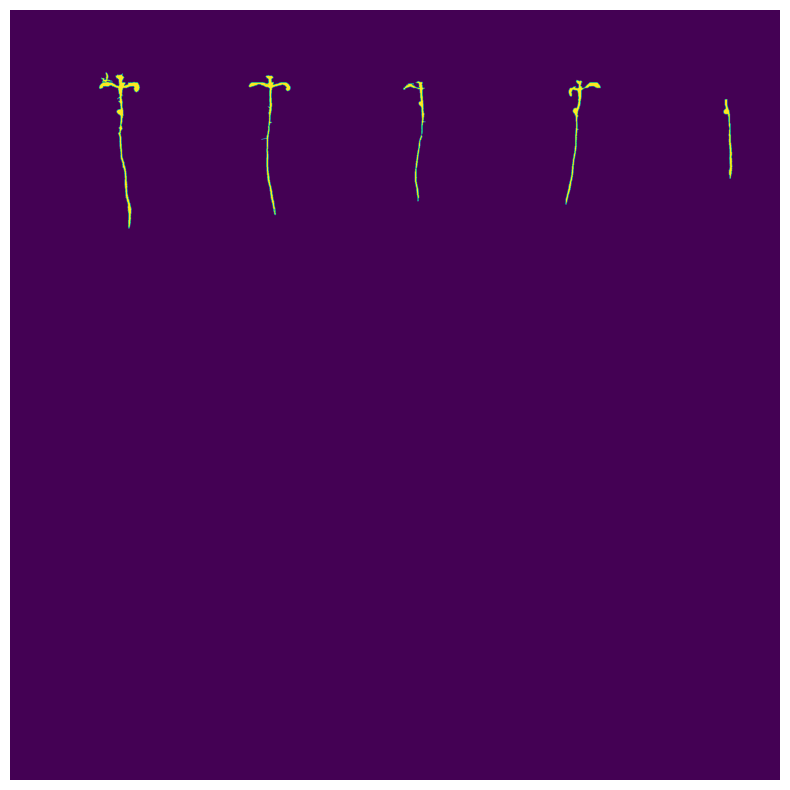

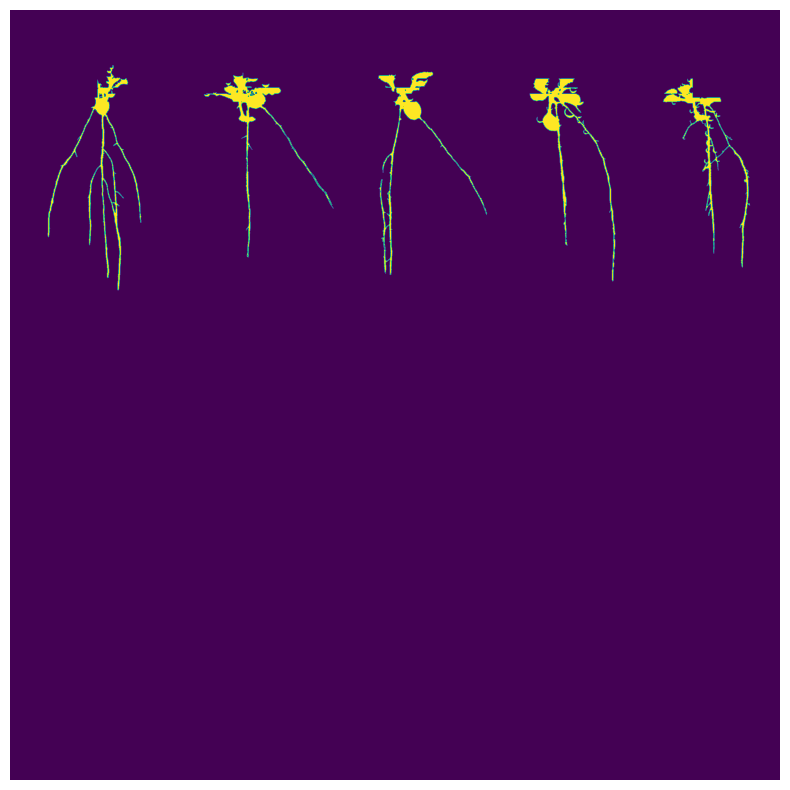

In [79]:
p1_result = process_and_trim_picture(p1)
p2_result = process_and_trim_picture(p2)